In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np
import datetime
from pathlib import Path
import os

from data_prep import *

import xgboost as xgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns 
xgb.set_config(verbosity=2)

pd.set_option('display.max_columns', 500)


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data_path = Path(os.getcwd()) / 'data' / 'WEC2022_Data'

In [3]:
data_path

WindowsPath('c:/wec_2022/wec_2022/data/WEC2022_Data')

In [6]:
# emd = pd.read_csv(data_path / 'EMD_train.csv', sep=';')

In [7]:
# df = df.merge(emd, how='left', left_on='TICKET_NUMBER', right_on='REFERENCE_TICKET_NUMBER')
# df.shape

In [8]:
# sus_air_type = (df[df['UPGRADED_FLAG'] == 'Y']['AIRCRAFT_TYPE'].value_counts() / df['AIRCRAFT_TYPE'].value_counts()).sort_values(ascending=False).head(5).index.tolist()

In [9]:
# sus_currency = (df[df['UPGRADED_FLAG'] == 1]['CURRENCY'].value_counts() / df['CURRENCY'].value_counts()).sort_values(ascending=False).head(6).index.tolist()

In [11]:
# sus_payment = (df[df['UPGRADED_FLAG'] == 1]['FORM_OF_PAYMENT'].value_counts() / df['FORM_OF_PAYMENT'].value_counts()).sort_values(ascending=False).head(9).index.tolist()

In [3]:
DATA_PATH = Path(os.getcwd()) / 'data' / 'WEC2022_Data'
MODEL_TYPE = 'predict_upgrade'
DATA_TYPE = 'train'

In [4]:
df = read_all_csv(data_path=data_path, data_type=DATA_TYPE, model_type=MODEL_TYPE)

In [5]:
clean_data = clean_df(data=df, data_path=data_path, data_type=DATA_TYPE, model_type=MODEL_TYPE)

In [6]:
final_df =  oh_encoding(clean_data)

In [7]:
X = final_df.drop(["UPGRADED_FLAG"], axis="columns")
y = final_df["UPGRADED_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [17]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.metrics import roc_auc_score


def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    gbm_model = xgb.train(params, dtrain, num_round,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

def optimize(trials):

    space = {
        'n_estimators': hp.quniform('n_estimators', 10, 300, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 16, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'aucpr',
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'auto',
        'scale_pos_weight': 1046.6532651902328,
        'tree_method': "gpu_hist",
        'gpu_id': 0,
    }

    best = fmin(score, 
                space, 
                algo=tpe.suggest,
                trials=trials, 
                max_evals=100)
    return best


In [18]:
trials = Trials()

best_hypers = optimize(trials)

Training with params:                                  
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.225, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 1.0, 'n_estimators': 16.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9714558004409954                              


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.35000000000000003, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 3.0, 'n_estimators': 260.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
  1%|          | 1/100 [00:21<35:07, 21.29s/trial, best loss: 0.028544199559004557]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9606957075124329                                                          


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.375, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 2.0, 'n_estimators': 137.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
  2%|▏         | 2/100 [02:13<2:02:23, 74.94s/trial, best loss: 0.028544199559004557]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9627333646588052                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.42500000000000004, 'eval_metric': 'aucpr', 'gamma': 0.55, 'gpu_id': 0, 'max_depth': 11, 'min_child_weight': 3.0, 'n_estimators': 91.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
  3%|▎         | 3/100 [03:15<1:51:02, 68.69s/trial, best loss: 0.028544199559004557]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9448330851092808                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 10, 'min_child_weight': 2.0, 'n_estimators': 71.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
  4%|▍         | 4/100 [03:55<1:32:21, 57.72s/trial, best loss: 0.028544199559004557]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9736775230246302                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.125, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 2.0, 'n_estimators': 96.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
  5%|▌         | 5/100 [04:27<1:16:11, 48.12s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9707160072045327                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.4, 'eval_metric': 'aucpr', 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 2, 'min_child_weight': 1.0, 'n_estimators': 175.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
  6%|▌         | 6/100 [04:50<1:02:26, 39.86s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9681646402582126                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.45, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 169.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
  7%|▋         | 7/100 [05:13<53:05, 34.25s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9717487572323003                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.4, 'eval_metric': 'aucpr', 'gamma': 0.55, 'gpu_id': 0, 'max_depth': 11, 'min_child_weight': 2.0, 'n_estimators': 217.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
  8%|▊         | 8/100 [05:50<53:39, 35.00s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9484762567173215                                                          


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.42500000000000004, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 11, 'min_child_weight': 3.0, 'n_estimators': 65.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
  9%|▉         | 9/100 [07:02<1:10:39, 46.59s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.945965746269051                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.4, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 10, 'min_child_weight': 1.0, 'n_estimators': 247.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
 10%|█         | 10/100 [07:34<1:03:24, 42.27s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.931285256658509                                                              


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 4, 'min_child_weight': 2.0, 'n_estimators': 127.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 11%|█         | 11/100 [08:56<1:20:29, 54.26s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9702274044700637                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 3, 'min_child_weight': 5.0, 'n_estimators': 119.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 12%|█▏        | 12/100 [09:20<1:06:13, 45.15s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.966143325002452                                                              


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.275, 'eval_metric': 'aucpr', 'gamma': 0.55, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 3.0, 'n_estimators': 129.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
 13%|█▎        | 13/100 [09:42<55:09, 38.04s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9637141954287155                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.47500000000000003, 'eval_metric': 'aucpr', 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 1.0, 'n_estimators': 18.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 14%|█▍        | 14/100 [09:59<45:26, 31.70s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9634609414905638                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.15000000000000002, 'eval_metric': 'aucpr', 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 2.0, 'n_estimators': 178.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
 15%|█▌        | 15/100 [10:21<40:45, 28.77s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9746506846516444                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.375, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 8, 'min_child_weight': 1.0, 'n_estimators': 274.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 16%|█▌        | 16/100 [11:11<49:11, 35.14s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9650529374030088                                                           


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.25, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 247.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
 17%|█▋        | 17/100 [12:16<1:00:57, 44.07s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9693969617643141                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.2, 'eval_metric': 'aucpr', 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 5.0, 'n_estimators': 79.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
 18%|█▊        | 18/100 [12:43<53:29, 39.15s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9646460741604217                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 243.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
 19%|█▉        | 19/100 [13:37<58:36, 43.41s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9737966596203256                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.15000000000000002, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 4.0, 'n_estimators': 300.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
 20%|██        | 20/100 [14:24<59:31, 44.64s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9731082093584305                                                           


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.17500000000000002, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 201.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
 21%|██        | 21/100 [15:38<1:10:29, 53.53s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9732347513715492                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 5.0, 'n_estimators': 208.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
 22%|██▏       | 22/100 [16:16<1:03:26, 48.80s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9753305501256632                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 208.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
 23%|██▎       | 23/100 [17:09<1:04:20, 50.14s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9741260048271306                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.30000000000000004, 'eval_metric': 'aucpr', 'gamma': 0.5, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 5.0, 'n_estimators': 194.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
 24%|██▍       | 24/100 [18:07<1:06:22, 52.40s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9624245459818961                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'aucpr', 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 13, 'min_child_weight': 6.0, 'n_estimators': 158.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
 25%|██▌       | 25/100 [19:01<1:05:53, 52.71s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9726581707746081                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.15000000000000002, 'eval_metric': 'aucpr', 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 5.0, 'n_estimators': 283.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
 26%|██▌       | 26/100 [20:11<1:11:24, 57.90s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9742816536907093                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.2, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 14, 'min_child_weight': 5.0, 'n_estimators': 232.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
 27%|██▋       | 27/100 [21:30<1:18:14, 64.30s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9699814955635968                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.225, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 188.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
 28%|██▊       | 28/100 [23:40<1:40:50, 84.04s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9685879176386348                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 3.0, 'n_estimators': 146.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
 29%|██▉       | 29/100 [24:36<1:29:36, 75.73s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9679159583831556                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.30000000000000004, 'eval_metric': 'aucpr', 'gamma': 0.5, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 4.0, 'n_estimators': 50.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 30%|███       | 30/100 [25:08<1:12:53, 62.48s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9735643864915194                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.125, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 2.0, 'n_estimators': 224.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
 31%|███       | 31/100 [25:30<58:04, 50.50s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9584889927875235                                                           


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.07500000000000001, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 5.0, 'n_estimators': 177.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
 32%|███▏      | 32/100 [27:02<1:11:23, 63.00s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9613521197508037                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.2, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 106.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
 33%|███▎      | 33/100 [27:23<56:02, 50.18s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9734084344668837                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.15000000000000002, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 14, 'min_child_weight': 2.0, 'n_estimators': 160.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
 34%|███▍      | 34/100 [27:52<48:10, 43.79s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9726397098375035                                                           


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.325, 'eval_metric': 'aucpr', 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 13, 'min_child_weight': 3.0, 'n_estimators': 272.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
 35%|███▌      | 35/100 [29:36<1:07:11, 62.03s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9293196198269028                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.25, 'eval_metric': 'aucpr', 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 8, 'min_child_weight': 1.0, 'n_estimators': 151.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
 36%|███▌      | 36/100 [31:30<1:22:49, 77.65s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9736005976009344                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 0.55, 'gpu_id': 0, 'max_depth': 4, 'min_child_weight': 6.0, 'n_estimators': 298.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
 37%|███▋      | 37/100 [32:08<1:08:53, 65.62s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9703337114069046                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 4.0, 'n_estimators': 180.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 38%|███▊      | 38/100 [32:48<1:00:02, 58.10s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9770807497421998                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.07500000000000001, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 4.0, 'n_estimators': 221.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 39%|███▉      | 39/100 [34:00<1:03:01, 61.99s/trial, best loss: 0.022919250257800172]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9773325434854027                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 4.0, 'n_estimators': 263.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 40%|████      | 40/100 [35:23<1:08:34, 68.57s/trial, best loss: 0.02266745651459734]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9777597336152383                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.07500000000000001, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 4.0, 'n_estimators': 266.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 41%|████      | 41/100 [37:03<1:16:42, 78.00s/trial, best loss: 0.02224026638476173]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9760553043862605                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 3.0, 'n_estimators': 282.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 42%|████▏     | 42/100 [38:50<1:23:48, 86.69s/trial, best loss: 0.02224026638476173]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9786616479265641                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 3.0, 'n_estimators': 285.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 43%|████▎     | 43/100 [40:38<1:28:14, 92.88s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.978297744669949                                                             


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.5, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 3.0, 'n_estimators': 288.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 44%|████▍     | 44/100 [42:27<1:31:18, 97.84s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9485601537670096                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 10, 'min_child_weight': 3.0, 'n_estimators': 252.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 45%|████▌     | 45/100 [43:56<1:27:10, 95.10s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9760872583010772                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.17500000000000002, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 11, 'min_child_weight': 2.0, 'n_estimators': 236.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 46%|████▌     | 46/100 [45:11<1:20:07, 89.03s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9705018159074645                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.125, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 3, 'min_child_weight': 3.0, 'n_estimators': 289.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 47%|████▋     | 47/100 [46:32<1:16:29, 86.59s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9707526730555327                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.35000000000000003, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 2, 'min_child_weight': 2.0, 'n_estimators': 37.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 48%|████▊     | 48/100 [47:04<1:00:57, 70.33s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9652365687407496                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 254.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 49%|████▉     | 49/100 [47:18<45:19, 53.31s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9725944300840739                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.125, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 1.0, 'n_estimators': 298.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 50%|█████     | 50/100 [48:14<45:12, 54.24s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9742162650240639                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.45, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 2.0, 'n_estimators': 278.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 51%|█████     | 51/100 [49:00<42:15, 51.75s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9518872924508763                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.225, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 3.0, 'n_estimators': 110.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
 52%|█████▏    | 52/100 [50:05<44:40, 55.84s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9686097533991315                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.275, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 3, 'min_child_weight': 2.0, 'n_estimators': 232.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 53%|█████▎    | 53/100 [51:16<47:08, 60.18s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9713717943272686                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.17500000000000002, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 4, 'min_child_weight': 1.0, 'n_estimators': 138.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 54%|█████▍    | 54/100 [51:43<38:39, 50.43s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9715348201098993                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 6, 'min_child_weight': 3.0, 'n_estimators': 84.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
 55%|█████▌    | 55/100 [52:07<31:52, 42.51s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9697018160866504                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.375, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 2.0, 'n_estimators': 212.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 56%|█████▌    | 56/100 [52:33<27:30, 37.52s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9655356297292298                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 10, 'min_child_weight': 3.0, 'n_estimators': 16.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 57%|█████▋    | 57/100 [52:53<23:10, 32.33s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9704447010113312                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 8, 'min_child_weight': 4.0, 'n_estimators': 199.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 58%|█████▊    | 58/100 [53:09<19:10, 27.39s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9764539617922922                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.225, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 11, 'min_child_weight': 3.0, 'n_estimators': 262.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 59%|█████▉    | 59/100 [53:55<22:32, 33.00s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9642063065438098                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 1.0, 'n_estimators': 300.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
 60%|██████    | 60/100 [55:24<33:01, 49.53s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9775400660094442                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.42500000000000004, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 243.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 61%|██████    | 61/100 [57:26<46:27, 71.47s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.97024171173098                                                            


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.07500000000000001, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 13, 'min_child_weight': 2.0, 'n_estimators': 284.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 62%|██████▏   | 62/100 [57:51<36:29, 57.61s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9754234674491569                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.17500000000000002, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 14, 'min_child_weight': 3.0, 'n_estimators': 190.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
 63%|██████▎   | 63/100 [1:00:00<48:33, 78.75s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9692908204261197                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.125, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 2.0, 'n_estimators': 167.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 64%|██████▍   | 64/100 [1:01:46<52:10, 86.95s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9728166177161536                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 4.0, 'n_estimators': 271.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 65%|██████▌   | 65/100 [1:02:15<40:41, 69.75s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9777871761607903                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 5.0, 'n_estimators': 272.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 66%|██████▌   | 66/100 [1:03:58<45:10, 79.71s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9760869277199651                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 4.0, 'n_estimators': 294.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 67%|██████▋   | 67/100 [1:05:41<47:38, 86.63s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9777970147229766                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 4.0, 'n_estimators': 291.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 68%|██████▊   | 68/100 [1:07:36<50:43, 95.12s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9781870076997365                                                            


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 3.0, 'n_estimators': 258.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 69%|██████▉   | 69/100 [1:09:32<52:20, 101.29s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9785362258224308                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 3.0, 'n_estimators': 251.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 70%|███████   | 70/100 [1:11:54<56:45, 113.52s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9771061764515777                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.15000000000000002, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 3.0, 'n_estimators': 225.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 71%|███████   | 71/100 [1:14:06<57:40, 119.32s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9771012909063943                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.125, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 3.0, 'n_estimators': 257.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 72%|███████▏  | 72/100 [1:16:13<56:41, 121.47s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9757529503724176                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 2.0, 'n_estimators': 236.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 73%|███████▎  | 73/100 [1:18:30<56:47, 126.21s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9763019605662473                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 282.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 74%|███████▍  | 74/100 [1:20:53<56:53, 131.29s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9726418148658784                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 6, 'min_child_weight': 2.0, 'n_estimators': 212.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 75%|███████▌  | 75/100 [1:21:59<46:26, 111.45s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9728762287615588                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.15000000000000002, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 3.0, 'n_estimators': 246.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 76%|███████▌  | 76/100 [1:22:38<35:53, 89.71s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9640657724463609                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.2, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 4, 'min_child_weight': 4.0, 'n_estimators': 277.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
 77%|███████▋  | 77/100 [1:23:04<27:09, 70.87s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9728713632422584                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 3, 'min_child_weight': 3.0, 'n_estimators': 268.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 78%|███████▊  | 78/100 [1:23:43<22:23, 61.08s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9664635986383827                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.35000000000000003, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 8, 'min_child_weight': 2.0, 'n_estimators': 203.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 79%|███████▉  | 79/100 [1:24:22<19:04, 54.50s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9706644989394085                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 10, 'min_child_weight': 3.0, 'n_estimators': 227.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 80%|████████  | 80/100 [1:25:14<17:53, 53.66s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9778274269529066                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.30000000000000004, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 13, 'min_child_weight': 4.0, 'n_estimators': 238.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 81%|████████  | 81/100 [1:26:22<18:25, 58.18s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9684547700110437                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.5, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 14, 'min_child_weight': 1.0, 'n_estimators': 260.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 82%|████████▏ | 82/100 [1:27:41<19:16, 64.27s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.8911110455206965                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.07500000000000001, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 11, 'min_child_weight': 2.0, 'n_estimators': 184.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
 83%|████████▎ | 83/100 [1:28:56<19:08, 67.57s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9762505505819947                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 3.0, 'n_estimators': 217.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
 84%|████████▍ | 84/100 [1:30:01<17:50, 66.91s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9753753777562763                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.4, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 33.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 85%|████████▌ | 85/100 [1:32:08<21:14, 84.97s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9652623120131213                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.25, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 63.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 86%|████████▌ | 86/100 [1:32:22<14:48, 63.44s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9740247913965636                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.17500000000000002, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 2.0, 'n_estimators': 98.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
 87%|████████▋ | 87/100 [1:32:42<10:58, 50.62s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9719802963354782                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.125, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 1.0, 'n_estimators': 167.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 88%|████████▊ | 88/100 [1:33:05<08:25, 42.12s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9736275336456958                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 3.0, 'n_estimators': 134.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 89%|████████▉ | 89/100 [1:34:12<09:06, 49.66s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9576561921110938                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 284.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 90%|█████████ | 90/100 [1:34:28<06:35, 39.59s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9707923377054632                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.45, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 4, 'min_child_weight': 5.0, 'n_estimators': 299.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 91%|█████████ | 91/100 [1:35:18<06:24, 42.73s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9725899379704656                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.15000000000000002, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 3.0, 'n_estimators': 123.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
 92%|█████████▏| 92/100 [1:35:56<05:30, 41.34s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9720031839169588                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.325, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 3, 'min_child_weight': 2.0, 'n_estimators': 195.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 93%|█████████▎| 93/100 [1:37:15<06:08, 52.67s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9708992392569789                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 10, 'min_child_weight': 4.0, 'n_estimators': 293.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 94%|█████████▍| 94/100 [1:37:40<04:26, 44.40s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9765749738889368                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 8, 'min_child_weight': 2.0, 'n_estimators': 252.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
 95%|█████████▌| 95/100 [1:39:03<04:38, 55.73s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9751416684635814                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.2, 'eval_metric': 'aucpr', 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 3.0, 'n_estimators': 143.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 96%|█████████▌| 96/100 [1:39:59<03:43, 55.96s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.971601283088136                                                             


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.125, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 13, 'min_child_weight': 5.0, 'n_estimators': 265.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 97%|█████████▋| 97/100 [1:41:10<03:01, 60.51s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9759910239211612                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 4.0, 'n_estimators': 218.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
 98%|█████████▊| 98/100 [1:43:08<02:35, 77.57s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9761328526149121                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.275, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 14, 'min_child_weight': 3.0, 'n_estimators': 277.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 99%|█████████▉| 99/100 [1:44:05<01:11, 71.69s/trial, best loss: 0.02133835207343593]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9663100845339126                                                            


100%|██████████| 100/100 [1:46:04<00:00, 63.65s/trial, best loss: 0.02133835207343593]


In [23]:
best_hypers['n_estimators'] = int(best_hypers['n_estimators'])

In [39]:

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=1046.6532651902328,
    seed=42,
    use_label_encoder=False,
    tree_method="gpu_hist",
    gpu_id=0, **best_hypers
)
xgb_model.fit(X, y, eval_metric="aucpr")


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eta=0.025, gamma=0.9, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.0250000004, max_delta_step=0, max_depth=11,
              min_child_weight=3.0, missing=nan, monotone_constraints='()',
              n_estimators=282, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1046.6532651902328, seed=42, subsample=0.9,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, ...)

In [25]:
def heatmap(model, y_test, X_test):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, model.predict(X_test))

    %matplotlib inline
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel("Predicted")
    plt.ylabel("Truth")

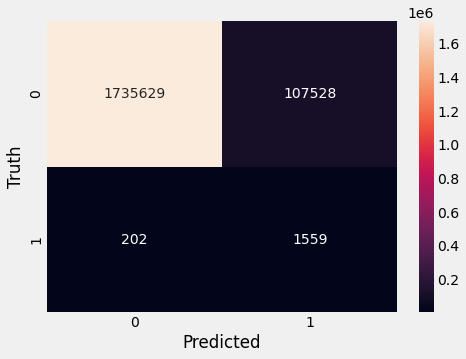

In [37]:
heatmap(xgb_model, y_test, X_test)

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Best Threshold=0.146081


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


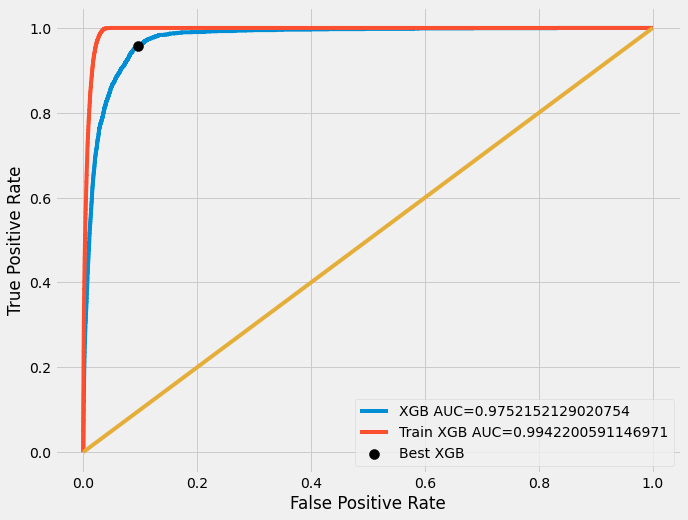

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

y_pred_proba2 = xgb_model.predict_proba(X_train)[::,1]
fpr2, tpr2, thresholds2 = roc_curve(y_train,  y_pred_proba2)
auc2 = roc_auc_score(y_train, y_pred_proba2)

# ROC
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label="XGB AUC="+str(auc))
plt.plot(fpr2, tpr2, label="Train XGB AUC="+str(auc2))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best XGB', s=100, zorder=3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.plot((0, 1), (0, 1))
plt.show()

In [13]:
test_df = read_all_csv(data_path, data_type='test')

In [15]:
clean_test = clean_df(test_df, data_type='test', data_path=data_path)

In [16]:
clean_test = oh_encoding(clean_test)

In [43]:
clean_test['SALES_CHANNEL_DCS'] = 0

In [44]:
preds = xgb_model.predict_proba(clean_test)[::,1]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [49]:
save = pd.DataFrame({'ticket_number': test_df['TICKET_NUMBER'], 'coupon_number': test_df['COUPON_NUMBER'], 'prediction': preds})

In [50]:
save.to_csv(data_path / 'KMO_TEAM_FCP_test_results_example_2.csv', sep=';', index=False)

In [54]:
sample_results = pd.read_csv(data_path / 'FCP_test_results_example.csv', sep=';',)

In [80]:
# {"Message": "Your Results - Area Under ROC Curve on test dataset:0.9326799484350818", "Ranking": {"Teams": {"1": "KMO_TEAM", "2": "FREELANCE_GLANCE"}}, "status": 200}

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Best Threshold=0.207122


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


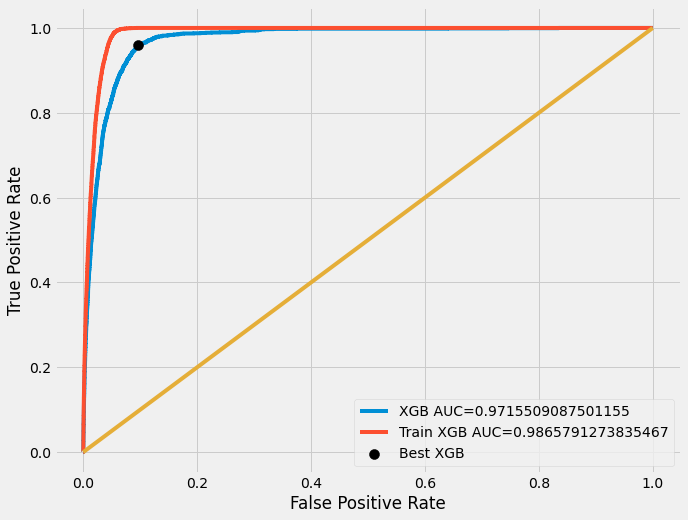

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

y_pred_proba2 = xgb_model.predict_proba(X_train)[::,1]
fpr2, tpr2, thresholds2 = roc_curve(y_train,  y_pred_proba2)
auc2 = roc_auc_score(y_train, y_pred_proba2)

# ROC
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label="XGB AUC="+str(auc))
plt.plot(fpr2, tpr2, label="Train XGB AUC="+str(auc2))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best XGB', s=100, zorder=3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.plot((0, 1), (0, 1))
plt.show()

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Best Threshold=0.207122


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


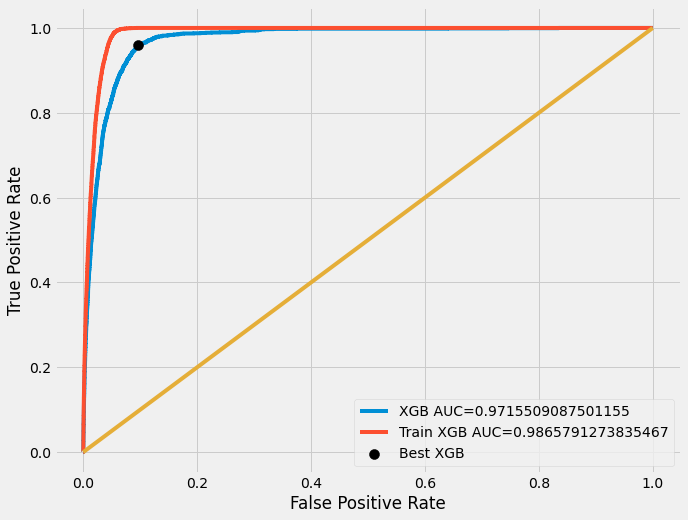

In [82]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

y_pred_proba2 = xgb_model.predict_proba(X_train)[::,1]
fpr2, tpr2, thresholds2 = roc_curve(y_train,  y_pred_proba2)
auc2 = roc_auc_score(y_train, y_pred_proba2)

# ROC
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label="XGB AUC="+str(auc))
plt.plot(fpr2, tpr2, label="Train XGB AUC="+str(auc2))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best XGB', s=100, zorder=3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.plot((0, 1), (0, 1))
plt.show()

Text(18.82, 0.5, 'Truth')

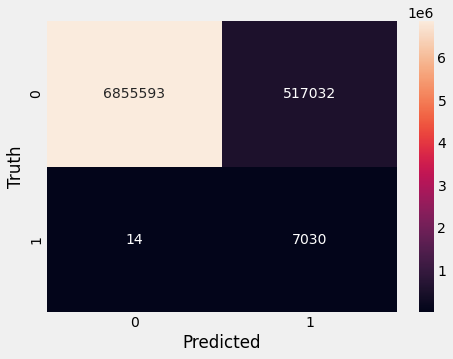

In [85]:
from sklearn.metrics import confusion_matrix
y_pred = (xgb_model.predict_proba(X_train)[:, 1] > 0.5).astype('float')
cm = confusion_matrix(y_train, y_pred)

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore')
xgb_model = xgb.XGBClassifier(scale_pos_weight = 1046.6532651902328, seed=42, use_label_encoder=False)
kfold = StratifiedKFold(n_splits=5)
results = cross_val_score(xgb_model, X, y, cv=kfold, scoring='roc_auc', fit_params={'eval_metric':'aucpr'})
print("średnia:", results.mean())
print('auc score:', results)

<BarContainer object of 40 artists>

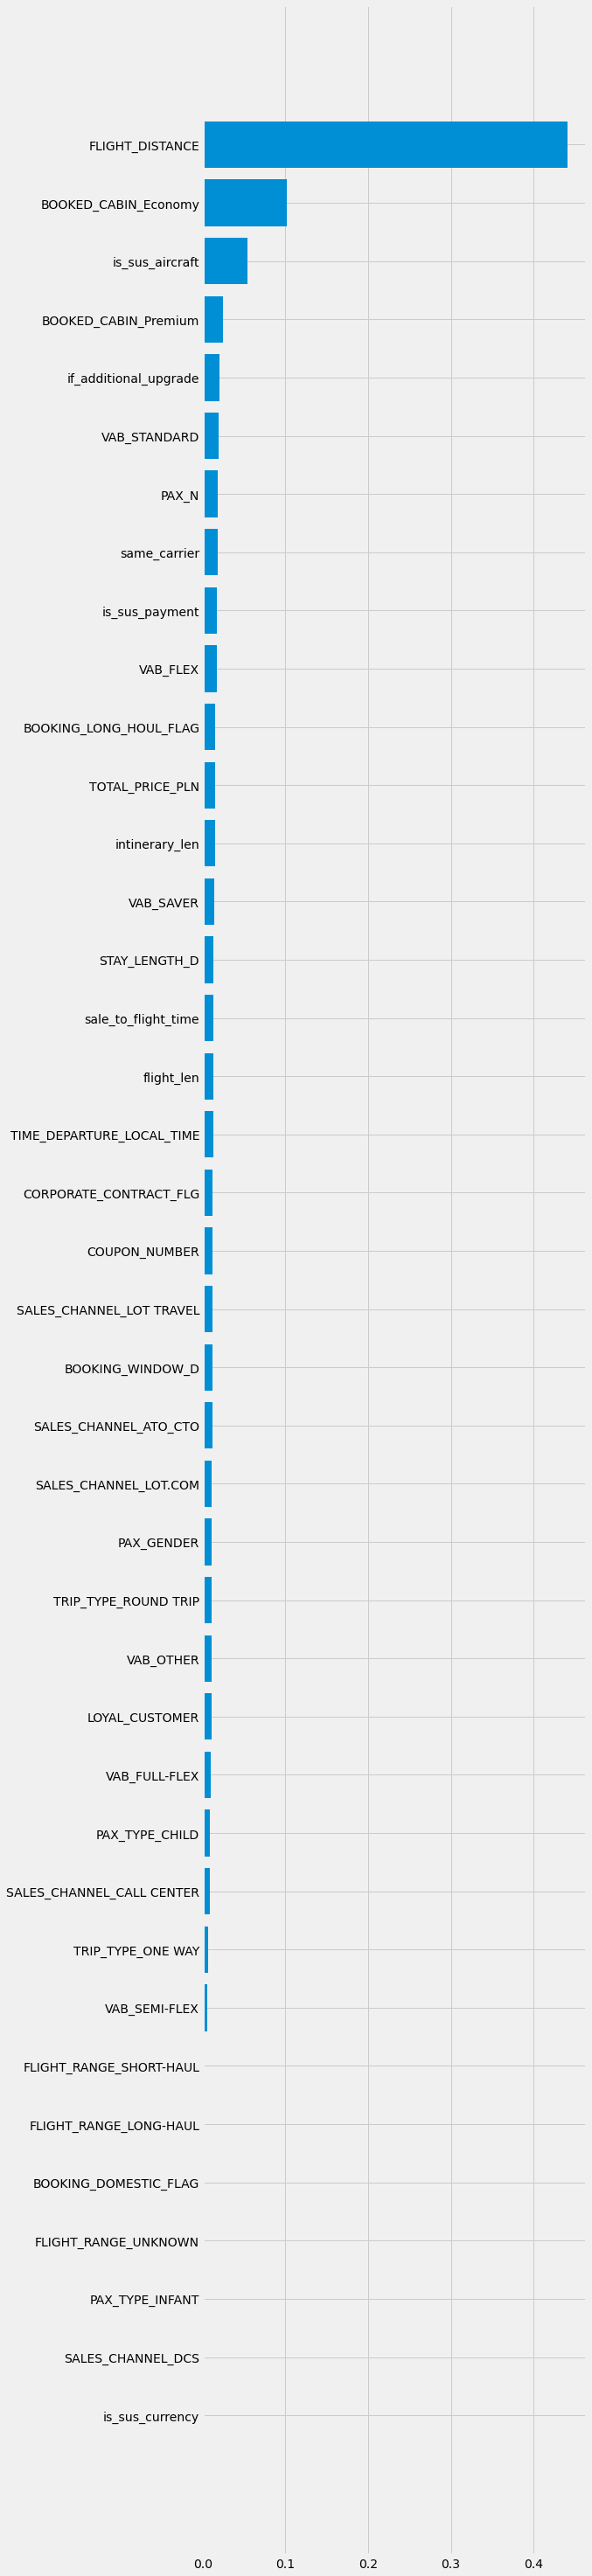

In [86]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(7,50))
plt.barh(X_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])

In [55]:
X[X['BOOKED_CABIN_Premium'] == 1]

,COUPON_NUMBER,TIME_DEPARTURE_LOCAL_TIME,FLIGHT_DISTANCE,TOTAL_PRICE_PLN,PAX_GENDER,CORPORATE_CONTRACT_FLG,LOYAL_CUSTOMER,BOOKING_WINDOW_D,STAY_LENGTH_D,BOOKING_LONG_HOUL_FLAG,BOOKING_DOMESTIC_FLAG,PAX_N,sale_to_flight_time,flight_len,if_additional_upgrade,same_carrier,is_sus_aircraft,is_sus_payment,intinerary_len,is_sus_currency,FLIGHT_RANGE_LONG-HAUL,FLIGHT_RANGE_SHORT-HAUL,FLIGHT_RANGE_UNKNOWN,BOOKED_CABIN_Economy,BOOKED_CABIN_Premium,VAB_FLEX,VAB_FULL-FLEX,VAB_OTHER,VAB_SAVER,VAB_SEMI-FLEX,VAB_STANDARD,PAX_TYPE_CHILD,PAX_TYPE_INFANT,SALES_CHANNEL_ATO_CTO,SALES_CHANNEL_CALL CENTER,SALES_CHANNEL_DCS,SALES_CHANNEL_LOT TRAVEL,SALES_CHANNEL_LOT.COM,TRIP_TYPE_ONE WAY,TRIP_TYPE_ROUND TRIP
10,3,19.0,1102,2889.55,1,0,1,3.0,4.0,0,0,1,7,5.583333,1,1,0,0,5,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
22,3,11.0,7747,3692.83,1,0,1,29.0,7.0,1,0,1,36,9.500000,0,1,1,1,5,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
26,1,10.0,537,2595.66,1,0,1,5.0,1.0,0,0,2,5,11.166667,0,1,0,1,3,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
150,1,11.0,7747,3769.50,1,0,0,4.0,NaN,1,0,1,4,14.333333,0,1,1,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
158,3,18.0,1036,1594.99,1,0,0,129.0,7.0,0,0,1,136,6.083333,0,1,0,1,5,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9224363,2,9.0,753,1892.01,1,0,1,15.0,2.0,0,0,1,17,15.416667,0,1,0,1,3,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
9224459,2,16.0,6863,4604.04,1,0,0,159.0,15.0,1,0,2,159,8.833333,0,1,1,0,5,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
9224541,2,15.0,482,3303.78,1,0,0,70.0,15.0,1,0,2,70,21.833333,0,1,0,0,6,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9224565,1,19.0,837,386.06,1,0,0,1.0,0.0,0,0,2,1,1.583333,0,1,0,0,2,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
X

,COUPON_NUMBER,TIME_DEPARTURE_LOCAL_TIME,FLIGHT_DISTANCE,TOTAL_PRICE_PLN,PAX_GENDER,CORPORATE_CONTRACT_FLG,LOYAL_CUSTOMER,BOOKING_WINDOW_D,STAY_LENGTH_D,BOOKING_LONG_HOUL_FLAG,BOOKING_DOMESTIC_FLAG,PAX_N,sale_to_flight_time,flight_len,if_additional_upgrade,same_carrier,is_sus_aircraft,is_sus_payment,intinerary_len,is_sus_currency,FLIGHT_RANGE_LONG-HAUL,FLIGHT_RANGE_SHORT-HAUL,FLIGHT_RANGE_UNKNOWN,BOOKED_CABIN_Economy,BOOKED_CABIN_Premium,VAB_FLEX,VAB_FULL-FLEX,VAB_OTHER,VAB_SAVER,VAB_SEMI-FLEX,VAB_STANDARD,PAX_TYPE_CHILD,PAX_TYPE_INFANT,SALES_CHANNEL_ATO_CTO,SALES_CHANNEL_CALL CENTER,SALES_CHANNEL_DCS,SALES_CHANNEL_LOT TRAVEL,SALES_CHANNEL_LOT.COM,TRIP_TYPE_ONE WAY,TRIP_TYPE_ROUND TRIP
0,2,19,1344,620.35,1,0,0,121.0,4.0,0,0,1,125,14.500000,0,1,0,0,3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
1,1,13,6942,2151.49,1,0,0,228.0,21.0,1,0,4,228,22.750000,0,1,1,0,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,16,7521,2270.18,0,0,0,55.0,15.0,1,0,1,69,22.250000,1,1,1,1,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1,6,721,1096.16,0,0,0,12.0,7.0,0,0,1,12,11.166667,0,1,0,0,5,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,2,18,522,752.15,1,0,0,6.0,1.0,0,0,1,7,23.500000,0,1,0,0,3,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9224582,1,19,523,813.64,1,0,0,0.0,NaN,0,0,1,0,4.666667,0,1,0,0,3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
9224583,2,17,1070,675.51,1,0,0,116.0,8.0,0,0,3,124,8.000000,0,1,0,0,3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
9224584,1,7,753,1408.80,1,0,0,36.0,NaN,0,0,1,36,5.833333,0,1,0,0,3,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9224585,1,18,940,1157.97,1,0,0,37.0,3.0,0,0,3,37,7.416667,1,1,0,0,3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [57]:
final_df.to_csv(data_path / 'full_dataset.csv')

In [17]:
clean_test

,COUPON_NUMBER,TIME_DEPARTURE_LOCAL_TIME,FLIGHT_DISTANCE,TOTAL_PRICE_PLN,PAX_GENDER,CORPORATE_CONTRACT_FLG,LOYAL_CUSTOMER,BOOKING_WINDOW_D,STAY_LENGTH_D,BOOKING_LONG_HOUL_FLAG,BOOKING_DOMESTIC_FLAG,PAX_N,sale_to_flight_time,flight_len,if_additional_upgrade,same_carrier,is_sus_aircraft,is_sus_payment,intinerary_len,is_sus_currency,FLIGHT_RANGE_LONG-HAUL,FLIGHT_RANGE_SHORT-HAUL,FLIGHT_RANGE_UNKNOWN,BOOKED_CABIN_Economy,BOOKED_CABIN_Premium,VAB_FLEX,VAB_FULL-FLEX,VAB_OTHER,VAB_SAVER,VAB_SEMI-FLEX,VAB_STANDARD,PAX_TYPE_CHILD,PAX_TYPE_INFANT,SALES_CHANNEL_ATO_CTO,SALES_CHANNEL_CALL CENTER,SALES_CHANNEL_LOT TRAVEL,SALES_CHANNEL_LOT.COM,TRIP_TYPE_ONE WAY,TRIP_TYPE_ROUND TRIP
0,2,13,252,2464.56,0,0,0,52.0,23.0,1,0,1,52,21.083333,0,1,0,0,5,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,4,14,6942,2887.25,1,0,0,126.0,30.0,1,0,2,156,19.250000,1,1,1,1,5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,11,721,127.13,1,0,0,46.0,1.0,0,0,2,46,3.833333,0,1,0,0,3,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
3,3,12,290,2887.25,1,0,0,126.0,30.0,1,0,2,156,19.250000,1,1,0,1,5,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,1,22,6942,2464.56,0,0,0,52.0,23.0,1,0,1,51,21.083333,0,1,1,0,5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47390,4,8,673,785.16,0,0,0,127.0,7.0,0,0,1,134,2.750000,0,1,0,0,5,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
47391,1,9,806,978.23,0,0,0,65.0,4.0,0,0,1,65,9.166667,1,1,0,1,3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
47392,1,7,1102,1757.06,1,0,0,20.0,3.0,0,0,1,20,11.833333,0,1,0,0,5,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
47393,2,13,1107,651.16,1,0,0,38.0,4.0,0,0,2,42,23.416667,0,1,0,0,3,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [18]:
clean_test.shape[0] - clean_test.dropna().shape[0]

8645

In [19]:
clean_test

,COUPON_NUMBER,TIME_DEPARTURE_LOCAL_TIME,FLIGHT_DISTANCE,TOTAL_PRICE_PLN,PAX_GENDER,CORPORATE_CONTRACT_FLG,LOYAL_CUSTOMER,BOOKING_WINDOW_D,STAY_LENGTH_D,BOOKING_LONG_HOUL_FLAG,BOOKING_DOMESTIC_FLAG,PAX_N,sale_to_flight_time,flight_len,if_additional_upgrade,same_carrier,is_sus_aircraft,is_sus_payment,intinerary_len,is_sus_currency,FLIGHT_RANGE_LONG-HAUL,FLIGHT_RANGE_SHORT-HAUL,FLIGHT_RANGE_UNKNOWN,BOOKED_CABIN_Economy,BOOKED_CABIN_Premium,VAB_FLEX,VAB_FULL-FLEX,VAB_OTHER,VAB_SAVER,VAB_SEMI-FLEX,VAB_STANDARD,PAX_TYPE_CHILD,PAX_TYPE_INFANT,SALES_CHANNEL_ATO_CTO,SALES_CHANNEL_CALL CENTER,SALES_CHANNEL_LOT TRAVEL,SALES_CHANNEL_LOT.COM,TRIP_TYPE_ONE WAY,TRIP_TYPE_ROUND TRIP
0,2,13,252,2464.56,0,0,0,52.0,23.0,1,0,1,52,21.083333,0,1,0,0,5,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,4,14,6942,2887.25,1,0,0,126.0,30.0,1,0,2,156,19.250000,1,1,1,1,5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,11,721,127.13,1,0,0,46.0,1.0,0,0,2,46,3.833333,0,1,0,0,3,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
3,3,12,290,2887.25,1,0,0,126.0,30.0,1,0,2,156,19.250000,1,1,0,1,5,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,1,22,6942,2464.56,0,0,0,52.0,23.0,1,0,1,51,21.083333,0,1,1,0,5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47390,4,8,673,785.16,0,0,0,127.0,7.0,0,0,1,134,2.750000,0,1,0,0,5,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
47391,1,9,806,978.23,0,0,0,65.0,4.0,0,0,1,65,9.166667,1,1,0,1,3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
47392,1,7,1102,1757.06,1,0,0,20.0,3.0,0,0,1,20,11.833333,0,1,0,0,5,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
47393,2,13,1107,651.16,1,0,0,38.0,4.0,0,0,2,42,23.416667,0,1,0,0,3,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [24]:
clean_test.isna().any()

COUPON_NUMBER                False
TIME_DEPARTURE_LOCAL_TIME    False
FLIGHT_DISTANCE              False
TOTAL_PRICE_PLN              False
PAX_GENDER                   False
CORPORATE_CONTRACT_FLG       False
LOYAL_CUSTOMER               False
BOOKING_WINDOW_D              True
STAY_LENGTH_D                 True
BOOKING_LONG_HOUL_FLAG       False
BOOKING_DOMESTIC_FLAG        False
PAX_N                        False
sale_to_flight_time          False
flight_len                    True
if_additional_upgrade        False
same_carrier                 False
is_sus_aircraft              False
is_sus_payment               False
intinerary_len               False
is_sus_currency              False
FLIGHT_RANGE_LONG-HAUL       False
FLIGHT_RANGE_SHORT-HAUL      False
FLIGHT_RANGE_UNKNOWN         False
BOOKED_CABIN_Economy         False
BOOKED_CABIN_Premium         False
VAB_FLEX                     False
VAB_FULL-FLEX                False
VAB_OTHER                    False
VAB_SAVER           

In [25]:
X = X.fillna(X.mean())

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)